In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import pandas as pd
import datetime
from tqdm import tqdm_notebook
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.ar_model import AR
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)

### Introduction

The idea behind this approach is to model the entire problem as a time series. This can be treated as a univariate time series problem within each Store-Department group.

We start by loading the data and processing it. The processing involves imputation of missing dates by resampling the date index, filling missing NaN values using interpolation, and filling negative "Weekly_Sales" values with zeros


In [3]:
def read_data(path):
    df = pd.read_csv(path, sep=',', header=0)
    return df
def next_weekday(d, weekday):
    days_ahead = weekday - d.weekday()
    if days_ahead <= 0: # Target day already happened this week
        days_ahead += 7
    return d + datetime.timedelta(days_ahead)
nans = lambda df: df[df.isnull().any(axis=1)].index


def get_data():
    ## Read in the train and test data
    train_df = read_data("train.csv")
    features_df = read_data("features.csv")
    stores_df = read_data("stores.csv")
    train_df = train_df.merge(stores_df, how='left').merge(features_df, how='left')
    train_df["Split"] = ["Train"]*len(train_df)
    test_df = read_data("test.csv")
    test_df = test_df.merge(stores_df, how='left').merge(features_df, how='left')
    test_df["Split"] = ["Test"]*len(test_df)
    # Combine both train and test dataframes to make processing easier
    full_df = pd.concat((train_df, test_df), axis=0)
    return full_df

if not os.path.exists("ts_train.csv"):
    full_df = get_data()
    # Change date to datetime type and add new Store_Dept column
    full_df["Date"] = pd.to_datetime(pd.to_datetime(full_df["Date"]), format='%Y-%m-%d')
    full_df["Store_Dept"] = full_df["Store"].astype(str) + "_" + full_df["Dept"].astype(str)
    
    # Choose useful columns for Time Series modeling and discard the rest
    full_df = full_df[["Date", "Store_Dept", "Weekly_Sales", "Split", "IsHoliday"]]
    
    # Replace negative values with 0
    full_df[full_df["Weekly_Sales"] < 0] = 0

    train_df = full_df[full_df["Split"] == "Train"].drop(columns=["Split"])
    test_df = full_df[full_df["Split"] == "Test"].drop(columns=["Split"])
    
    
    new_train_df = pd.DataFrame()
    new_test_df = pd.DataFrame()
    

    # Resample dates to include missing weeks
    for sd in tqdm_notebook(sorted(list(set(train_df["Store_Dept"])))):
        temp_df = train_df[train_df["Store_Dept"] == sd]
        temp_df = temp_df.set_index("Date").resample("W-FRI").mean().reset_index()
        temp_df.Weekly_Sales = temp_df.Weekly_Sales.interpolate()
        assert len(nans(temp_df)) == 0
        temp_test_df = test_df[test_df["Store_Dept"] == sd]
        if len(temp_test_df) > 0:
            temp_test_df = temp_test_df.set_index("Date").resample("W-FRI").mean().reset_index()
            temp_test_df["Store_Dept"] = [sd]*len(temp_test_df)
        
        temp_df["Store_Dept"] = [sd]*len(temp_df)
        new_train_df = pd.concat((new_train_df, temp_df), axis=0)
        new_test_df = pd.concat((new_test_df, temp_test_df), axis=0)

    # Rename
    new_train_df = new_train_df.reset_index()
    new_test_df = new_test_df.reset_index().drop(columns=["Weekly_Sales"])

    # Save dataframes to disk
    new_train_df.to_csv("ts_train.csv", index=False)
    new_test_df.to_csv("ts_test.csv", index=False)
    full_df.to_csv("full.csv", index=False)
      
else:
    full_df = pd.read_csv("full.csv")
    new_train_df = pd.read_csv("ts_train.csv")
    new_test_df = pd.read_csv("ts_test.csv")

Visualize what the imputed time series looks like for some Store-Dept pairs

<IPython.core.display.Javascript object>


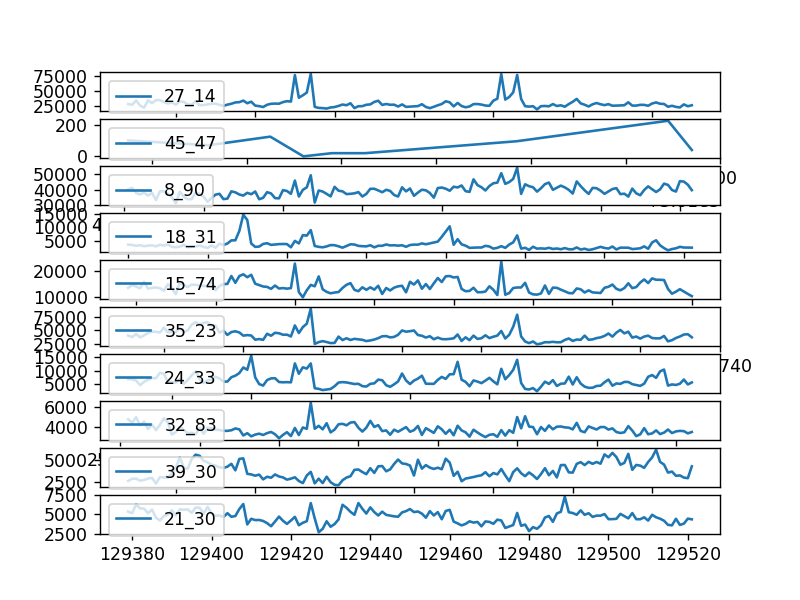

In [7]:

%matplotlib notebook
sds = list(set(new_train_df["Store_Dept"]))
fig, ax = plt.subplots(10, 1)
for i in range(10):
    df = new_train_df[new_train_df["Store_Dept"] == sds[i]]
    ax[i].plot(df.Weekly_Sales, label=sds[i])
    ax[i].legend(loc='upper left')

,index,Date,IsHoliday,Store_Dept
0,0,2012-11-02,NaN,10_1
1,1,2012-11-09,NaN,10_1
2,2,2012-11-16,NaN,10_1
3,3,2012-11-23,NaN,10_1
4,4,2012-11-30,NaN,10_1


### Time Series Modeling using STL decomposition

STL Decomposition - Seasonal and Trend decomposition using Loess is a method for estimating nonlinear relationships. The STL method was developed by Cleveland, Cleveland, McRae, & Terpenning (1990).
Advantages of STL over classical techniques: 
1. STL will handle any type of seasonality, not only monthly and quarterly data.
2. The seasonal component is allowed to change over time, and the rate of change can be controlled by the user.
3. The smoothness of the trend-cycle can also be controlled by the user.
4. It can be robust to outliers (i.e., the user can specify a robust decomposition), so that occasional unusual observations will not affect the estimates of the trend-cycle and seasonal components. They will, however, affect the remainder component.


1. N Time Series models are created, one for each unique Store_Dept pair present in the training set. 
2. Each time series model is created by first separating the trend, seasonal and residual components (by using STL decomposition technique), and modeling each component by an autoregressive model.
3. A forecast is obtained for each component on the test set and summed together for the final forecast values. This is known as Additive Decomposition as opposed to Multiplicative Decomposition where the components are multiplied instead. Multiplication is used for economic time series that show exponential variations. For our purpose, additive is required.
4. Department average across stores is used to impute final output missing sales values. If there are more NaNs left, imputation is carried out with Store sales average across departments.



In [8]:
new_train_df["Date"] = pd.to_datetime(new_train_df["Date"])
new_test_df["Date"] = pd.to_datetime(new_test_df["Date"])
results = pd.DataFrame()
for sd in tqdm_notebook(set(full_df["Store_Dept"])):
    temp_train = new_train_df[new_train_df["Store_Dept"] == sd]
    temp_train = temp_train.set_index("Date")
    temp_test = new_test_df[new_test_df["Store_Dept"] == sd]
    if len(temp_train) > 10:
        short_obs = temp_train.Weekly_Sales.head(2*len(temp_train)//3)
        try:
            short_decomp = decompose(short_obs, period=52)
            fcast = forecast(short_decomp, steps=len(temp_train), fc_func=drift, seasonal=True).reset_index()
            fcast.columns = ["Date", "Weekly_Sales"]
            temp_test = pd.merge(temp_test, fcast, how="left", on="Date")
            results = pd.concat((results, temp_test), axis=0)
        except:
            print("Skipping ", sd)
            pass

<IPython.core.display.Javascript object>


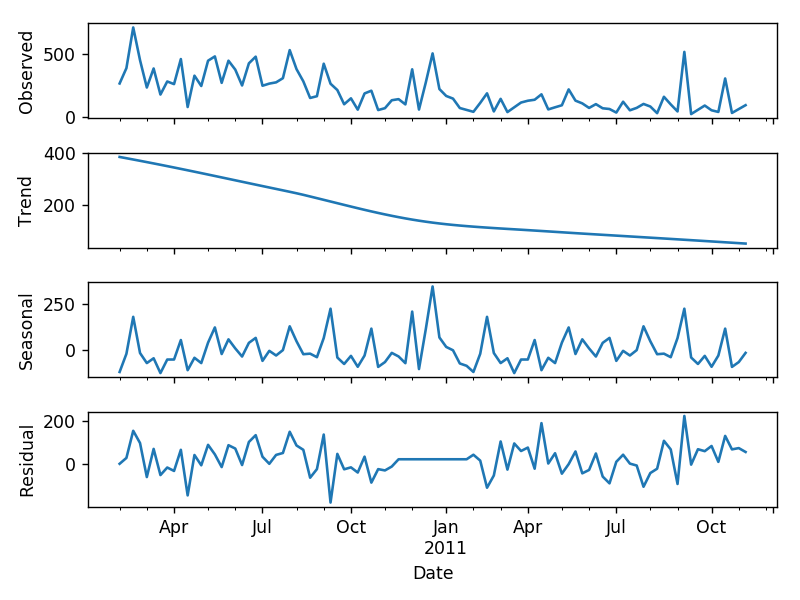

<IPython.core.display.Javascript object>


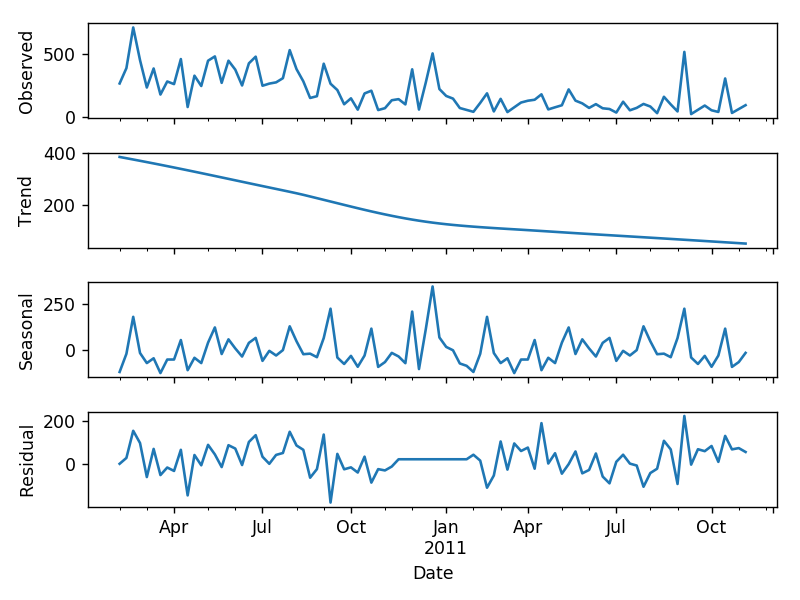

In [49]:
short_decomp.plot()

Forecast on the test set and impute missing values.

In [45]:
final_test_df = pd.read_csv("test.csv")[["Date", "Store", "Dept"]]
final_test_df["Id"] = final_test_df["Store"].astype(str) + "_" + final_test_df["Dept"].astype(str) + "_" + final_test_df["Date"].astype(str)
results["Id"] = results["Store_Dept"] + "_" + results["Date"].astype(str)
final_results = pd.merge(final_test_df, results, on="Id", how="left")[["Id", "Weekly_Sales", "Store_Dept", "Store", "Dept"]]

# Nans still exist in the output.csv because of Store_Dept pairs note present in training set
dept_medians = final_results.groupby("Dept").median().reset_index()
dept_medians.columns = ["Dept", "Dept_Medians", "Store"]
final_results = final_results.merge(dept_medians, how="left", on="Dept")

final_results = final_results.drop(columns=["Store_y"])
final_results.columns = ["Id", "Weekly_Sales", "Store_Dept", "Store", "Dept", "Dept_Medians"]
final_results.head()


,Id,Weekly_Sales,Store_Dept,Store,Dept,Dept_Medians
0,1_1_2012-11-02,34760.764228,1_1,1,1,17361.400681
1,1_1_2012-11-09,16788.485561,1_1,1,1,17361.400681
2,1_1_2012-11-16,16939.829749,1_1,1,1,17361.400681
3,1_1_2012-11-23,17473.481534,1_1,1,1,17361.400681
4,1_1_2012-11-30,19411.672954,1_1,1,1,17361.400681


In [41]:
sum(np.isnan(final_results["Weekly_Sales"]))

433

In [46]:
store_medians = final_results.groupby("Store").median().reset_index()[["Store", "Weekly_Sales"]]
store_medians.columns = ["Store", "Store_Medians"]
final_results = pd.merge(final_results, store_medians, how="left", on="Store")
final_results["Weekly_Sales"] = final_results["Weekly_Sales"].fillna(final_results["Dept_Medians"]).fillna(final_results["Store_Medians"])
final_results.head()
sum(np.isnan(final_results["Weekly_Sales"]))


0

In [47]:
# Save to output file
final_results[["Id", "Weekly_Sales"]].to_csv("output_stl.csv", index=False)

### ARIMA - https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average

##### Fit ARIMA model

In [50]:
def calc_mae(y_pred, y_gt, weights):
    diffs = np.multiply(np.abs(np.array(y_pred) - np.array(y_gt)), np.array(weights))
    mae = sum(diffs)/np.sum(weights)
    return mae
def create_time_series_model(train_data, type="sarima"):
    if type == "arima":
        from statsmodels.tsa.arima_model import ARIMA
        # fit model
        model = ARIMA(train_data, order=(1, 1, 1))
        model_fit = model.fit(disp=False)
        
    elif type == "sarima":
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 1))
        model_fit = model.fit(disp=False)
        
    elif type == "ar":
        from statsmodels.tsa.ar_model import AR
        model = AR(train_data)
        model_fit = model.fit()
    return model_fit


In [ ]:
import itertools
import collections
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

sds = list(set(new_train_df["Store_Dept"]))

model_dic = collections.defaultdict(dict)
for i in tqdm_notebook(range(2)):
    print("Store_Dept: ", sds[i])
    temp = new_train_df[new_train_df["Store_Dept"] == sds[i]]
    temp_valid = new_valid_df[new_valid_df["Store_Dept"] == sds[i]]
    num_forecasts = len(temp_valid) - 1
    
    best_model = None
    param_string = ""
    min_aic = float("inf")
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                
                mod = sm.tsa.statespace.SARIMAX(temp.Weekly_Sales,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                
                if results.aic < min_aic:
                    best_model = results
                    min_aic = results.aic
                    param_string = 'Store_Dept {} ARIMA{}x{}12 - AIC:{}'.format(sds[i], param, param_seasonal, results.aic)
            except:
                print("Validation failed or could not build model")
                continue
    model_dic[sds[i]]["model"] = best_model
    model_dic[sds[i]]["aic"] = min_aic
    model_dic[sds[i]]["param_string"] = param_string
    #model_dic[sds[i]]["mae"] = mae
    # Save the best model for this time series into a dictionary